In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

import ray
import time
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import torch
from torch import nn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
def define_pandas_options():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
def string_to_vector(s):
    try:
        s = s.split('[')[1].split(']')[0]
        x = float(s.split()[0])
        y = float(s.split()[1])
        return np.array([x, y])
    except AttributeError:
        return None


def get_position_delta(row):
    return row.s / 10 * row.dir_vec


def get_relative_position(row):
    if row.frameId == 1:
        return np.array([0, 0])
    else:
        last_pos = row.shift(1).rel_pos
        return last_pos + row.pos_delta

In [6]:
# Prep data
prog_start = time.time()
pl_cols = ['gameId', 'playId', 'offense_h_play', 'offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived',
           'offense_h_to_end', 'defense_h_play', 'defense_h_presnap', 'defense_h_to_throw', 'defense_h_to_arrived',
           'defense_h_to_end', 'offense_p_play', 'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
           'offense_p_to_end', 'offense_m_play', 'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived',
           'offense_m_to_end', 'offense_v_play', 'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived',
           'offense_v_to_end', 'offense_a_play', 'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
           'offense_a_to_end', 'defense_p_play', 'defense_p_presnap', 'defense_p_to_throw', 'defense_p_to_arrived',
           'defense_p_to_end', 'defense_m_play', 'defense_m_presnap', 'defense_m_to_throw', 'defense_m_to_arrived',
           'defense_m_to_end', 'defense_v_play', 'defense_v_presnap', 'defense_v_to_throw', 'defense_v_to_arrived',
           'defense_v_to_end', 'defense_a_play', 'defense_a_presnap', 'defense_a_to_throw', 'defense_a_to_arrived',
           'defense_a_to_end', 'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE',
           'POST', 'WHEEL']

play_df = pd.read_csv('d20_intermediate_files/play_results.csv', usecols=pl_cols)
play_df['num_routes'] = play_df[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']].T.sum()
play_df.drop(play_df[play_df['num_routes'] == 0].index, inplace=True)
play_df.dropna(inplace=True)

fr_cols = ['gameId', 'playId', 'frameId', 'offense_p_group', 'defense_p_group', 'offense_m_group', 'defense_m_group',
           'o_state', 'd_state', 'offense_v_group', 'defense_v_group', 'offense_a_group', 'defense_a_group',
           'a_group_ratio']
frame_df = pd.read_csv('d20_intermediate_files/frame_results.csv', usecols=fr_cols)

#tr_cols = ['time', 's', 'a', 'dis', 'event', 'nflId', 'displayName', 'jerseyNumber', 'position', 'frameId', 'team', 'gameId', 'playId', 'playDirection', 'route', 'pos', 'teamType', 'o_vec', 'dir_vec', 'r_vec']
#tracking_df = pd.read_csv('d20_intermediate_files/tracking_results.csv', usecols=tr_cols)

In [7]:
play_df.head()

,gameId,playId,offense_h_play,offense_h_presnap,offense_h_to_throw,offense_h_to_arrived,offense_h_to_end,defense_h_play,defense_h_presnap,defense_h_to_throw,...,CROSS,GO,SLANT,SCREEN,CORNER,IN,ANGLE,POST,WHEEL,num_routes
0,2018090600,75,5.145521,-0.000000,4.733452,4.306341,4.764014,4.750136,-0.000000,4.008848,...,0,0,0,0,0,0,0,0,0,4
1,2018090600,146,4.239564,0.722081,4.249899,3.185872,4.265621,4.872203,1.546312,3.939565,...,1,0,0,0,0,0,0,0,0,5
3,2018090600,190,5.360222,-0.000000,5.278721,4.789590,3.919888,5.203300,2.119310,4.312658,...,0,0,0,0,1,1,0,0,0,3
4,2018090600,256,4.182727,0.592412,3.949740,4.065981,3.628376,4.317301,2.181818,3.593447,...,0,2,0,0,0,0,0,0,0,3
5,2018090600,320,4.865316,0.856801,4.486656,4.609067,4.348052,4.907033,1.471890,4.277658,...,0,0,0,0,0,0,1,0,0,5


In [72]:
play_df.describe()

,gameId,playId,offense_h_play,offense_h_presnap,offense_h_to_throw,offense_h_to_arrived,offense_h_to_end,defense_h_play,defense_h_presnap,defense_h_to_throw,...,CROSS,GO,SLANT,SCREEN,CORNER,IN,ANGLE,POST,WHEEL,num_routes
count,6.053000e+03,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000,...,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000
mean,2.018107e+09,2175.908971,4.891404,0.212278,4.670505,3.961326,4.315888,5.217516,1.288699,4.502479,...,0.389724,0.871138,0.324798,0.224021,0.146043,0.317033,0.175450,0.268627,0.019164,4.579052
std,1.139088e+04,1256.228321,0.471664,0.365859,0.589313,0.404033,0.665939,0.465863,0.754770,0.653425,...,0.651101,0.914874,0.650569,0.522499,0.378036,0.560399,0.385561,0.508879,0.137113,0.652341
min,2.018091e+09,51.000000,2.665374,-0.000000,1.159672,2.218546,1.251629,3.235330,-0.000000,0.514318,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.018100e+09,1113.000000,4.590837,0.000000,4.375753,3.693902,3.846840,4.929675,0.735127,4.126828,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
50%,2.018110e+09,2186.000000,4.903628,0.000000,4.734094,3.959441,4.349947,5.257174,1.242202,4.582293,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
75%,2.018120e+09,3240.000000,5.218962,0.308506,5.051784,4.231135,4.812020,5.542995,1.776322,4.963587,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,5.000000
max,2.018123e+09,5637.000000,6.601220,3.171627,6.179106,5.573548,6.514224,6.663877,3.824150,6.128508,...,4.000000,4.000000,5.000000,4.000000,2.000000,4.000000,2.000000,3.000000,1.000000,5.000000


In [248]:
def draw_prob_density(x_series, y_series, x_bins, y_bins, ax, xlab=None, ylab=None, cbar=True):
    dims = {'x': x_series.max() * 1.00001, 'y': y_series.max() * 1.00001}

    bins = np.zeros(x_bins * y_bins).reshape(y_bins, x_bins)
    rows = min(len(y_series), len(x_series))

    for row in range(rows):
        i = int(x_series.iloc[row] / dims['x'] * x_bins)
        j = int(y_series.iloc[row] / dims['y'] * y_bins)
        bins[j][i] += 1

    smoothing_grid = np.zeros(x_bins * y_bins).reshape(y_bins, x_bins)
    for i in range(x_bins):
        for j in range(y_bins):
            sum = 0
            count = 0
            for x in range(-1, 2):
                for y in range(-1, 2):
                    if 0 <= i + x < x_bins and 0 <= j + y < y_bins:
                        sum += bins[j + y][i + x]
                        count += 1
            smoothing_grid[j][i] = sum / count

    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    if cbar:
        c = ax.pcolor(smoothing_grid, cmap='jet')
        plt.colorbar(c, ax=ax)
    else:
        ax.pcolor(smoothing_grid, cmap='jet')

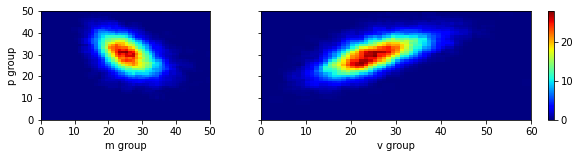

In [249]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 2), gridspec_kw={'width_ratios': [1, 2]})

draw_prob_density(play_df['offense_m_play'], play_df['offense_p_play'], 50, 50, axs[0], 'm group', 'p group', cbar=False)
draw_prob_density(play_df['offense_v_play'], play_df['offense_p_play'], 60, 50, axs[1], 'v group')

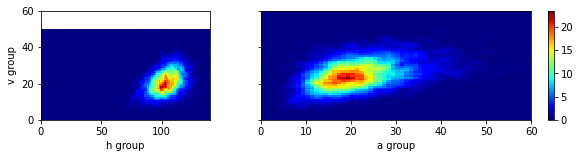

In [250]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 2), gridspec_kw={'width_ratios': [1, 2]})

draw_prob_density(play_df['offense_h_play'], play_df['offense_v_play'], 140, 50, axs[0], 'h group', 'v group', cbar=False)
draw_prob_density(play_df['offense_a_play'], play_df['offense_v_play'], 60, 60, axs[1], 'a group')

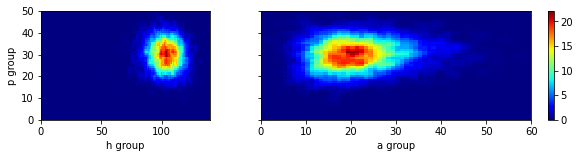

In [251]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 2), gridspec_kw={'width_ratios': [1, 2]})

draw_prob_density(play_df['offense_h_play'], play_df['offense_p_play'], 140, 50, axs[0], 'h group', 'p group', cbar=False)
draw_prob_density(play_df['offense_a_play'], play_df['offense_p_play'], 60, 50, axs[1], 'a group')

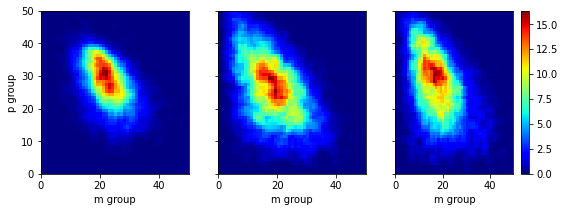

In [259]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(9, 3), gridspec_kw={'width_ratios': [1, 1, 1]})

draw_prob_density(play_df['offense_m_to_throw'], play_df['offense_p_to_throw'], 50, 50, axs[0], 'm group', 'p group', cbar=False)
draw_prob_density(play_df['offense_m_to_arrived'], play_df['offense_p_to_arrived'], 50, 50, axs[1], 'm group', cbar=False)
draw_prob_density(play_df['offense_m_to_end'], play_df['offense_p_to_end'], 50, 50, axs[2], 'm group')

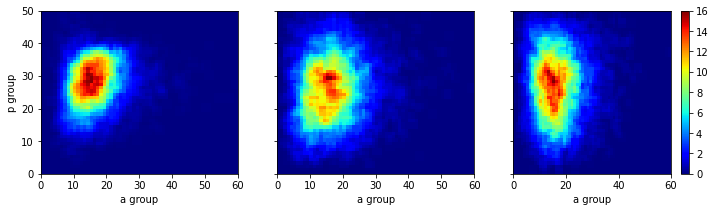

In [258]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 3), gridspec_kw={'width_ratios': [1, 1, 1]})

draw_prob_density(play_df['offense_a_to_throw'], play_df['offense_p_to_throw'], 60, 50, axs[0], 'a group', 'p group', cbar=False)
draw_prob_density(play_df['offense_a_to_arrived'], play_df['offense_p_to_arrived'], 60, 50, axs[1], 'a group', cbar=False)
draw_prob_density(play_df['offense_a_to_end'], play_df['offense_p_to_end'], 60, 50, axs[2], 'a group')

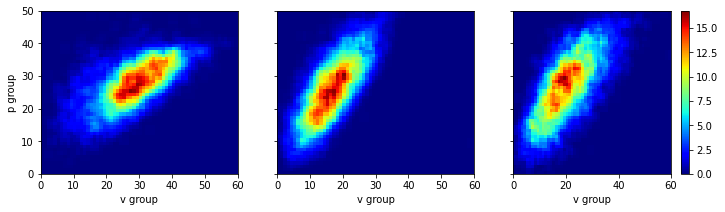

In [260]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 3), gridspec_kw={'width_ratios': [1, 1, 1]})

draw_prob_density(play_df['offense_v_to_throw'], play_df['offense_p_to_throw'], 60, 50, axs[0], 'v group', 'p group',
                  cbar=False)
draw_prob_density(play_df['offense_v_to_arrived'], play_df['offense_p_to_arrived'], 60, 50, axs[1], 'v group',
                  cbar=False)
draw_prob_density(play_df['offense_v_to_end'], play_df['offense_p_to_end'], 60, 50, axs[2], 'v group')

In [ ]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 3), gridspec_kw={'width_ratios': [1, 1, 1]})

draw_prob_density(play_df['offense_v_to_throw'], play_df['offense_p_to_throw'], 60, 50, axs[0], 'v group', 'p group',
                  cbar=False)
draw_prob_density(play_df['offense_v_to_arrived'], play_df['offense_p_to_arrived'], 60, 50, axs[1], 'v group',
                  cbar=False)
draw_prob_density(play_df['offense_v_to_end'], play_df['offense_p_to_end'], 60, 50, axs[2], 'v group')